# Autoencoder for image compression

## 1. Notebook setup

### 1.1. Imports

In [1]:
# Standard library
# import os
import sys
from pathlib import Path

# Third-party
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

# Add src directory to path
sys.path.append(str(Path.cwd().parent))

# Local imports
from src.data_utils import COCO_CLASSES, load_coco_cached
from src.metrics import compute_metrics_summary
from src.model_utils import build_compression_ae
from src.visualization import plot_image_grid, plot_reconstruction_comparison, plot_training_history
from src.huggingface_utils import download_model, upload_model


### 1.2. Configuration

In [2]:
# Training configuration
TRAIN_MODEL = True  # Set to False to download pre-trained models from HuggingFace

# Training hyperparameters
latent_dims = [32, 64, 128, 256]
epochs = 50
batch_size = 128
learning_rate = 0.001

# Create models directory
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Create logs directory for TensorBoard
logs_dir = Path('../logs')
logs_dir.mkdir(exist_ok=True)

# Set random seeds for reproducibility
np.random.seed(315)
tf.random.set_seed(315)

# Configure GPU
# GPU configuration
GPU_ID = 0  # Which GPU to use (0-indexed). Set to None to use all available GPUs.
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        if GPU_ID is not None:

            # Use specific GPU
            tf.config.set_visible_devices(gpus[GPU_ID], 'GPU')
            tf.config.experimental.set_memory_growth(gpus[GPU_ID], True)
            print(f'Using GPU {GPU_ID}: {gpus[GPU_ID].name}')

        else:

            # Use all GPUs with memory growth
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            print(f'Using {len(gpus)} GPU(s): {[gpu.name for gpu in gpus]}')

    except RuntimeError as e:
        print(e)
else:
    print('No GPU available, using CPU')

Using GPU 0: /physical_device:GPU:0


## 2. Data preparation

COCO (Common Objects in Context) is a large-scale dataset with ~118K training images across 80 diverse categories. We use a 10% subset (~11,800 images) for efficient training while maintaining diversity.

### 2.1. Load COCO dataset

In [3]:
# Load COCO dataset (10% subset with caching)
# First run: Downloads full COCO (~95GB) and saves 10% subset to ../data/
# Subsequent runs: Loads quickly from cached subset file
(x_train, y_train), (x_test, y_test) = load_coco_cached(subset_percent=10, normalize=True)

print(f'\nTraining set: {x_train.shape}')
print(f'Test set: {x_test.shape}')
print(f'Image shape: {x_train.shape[1:]}')
print(f'Number of classes: {len(COCO_CLASSES)}')


Local cache not found. Attempting to download from Hugging Face Hub...
This is much faster than downloading the full 95GB COCO dataset!
Could not download from Hugging Face: 401 Client Error. (Request ID: Root=1-699648c3-0d76c71249903e2671416cb1;f279242f-d925-47c0-aa5e-6d286dea72d3)

Repository Not Found for url: https://huggingface.co/mrdbourke/autoencoders-demo/resolve/main/data/coco_10percent_subset.npz.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated. For more details, see https://huggingface.co/docs/huggingface_hub/authentication
Invalid username or password.
Falling back to TensorFlow Datasets (this will download ~95GB)...
This will take some time on first run (~95GB total download).
Future runs will load from: ../data/coco_10percent_subset.npz


2026-02-18 23:18:33.430790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-18 23:18:34.203467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Saving subset to cache...
Cached to: ../data/coco_10percent_subset.npz

Training set: (11829, 64, 64, 3)
Test set: (1000, 64, 64, 3)
Image shape: (64, 64, 3)
Number of classes: 80


### 2.2. Sample images

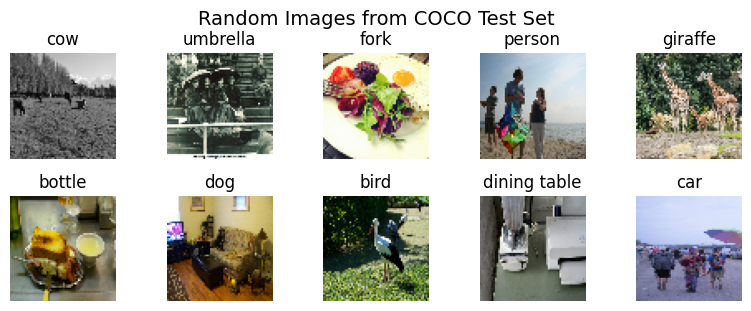

In [4]:
# Visualize some random samples
n_samples = 10
indices = np.random.choice(len(x_test), n_samples, replace=False)
samples = x_test[indices]
labels = [COCO_CLASSES[y_test[i]] for i in indices]

fig = plot_image_grid(samples, titles=labels)
plt.suptitle('Random Images from COCO Test Set', fontsize=14, y=1.02)
plt.show()

## 3. Compression autoencoders

We'll train separate models with different latent dimensions to explore the compression-quality trade-off:

- **Latent dim 32**: Highest compression (~99.7% size reduction, 384x compression)
- **Latent dim 64**: Very high compression (~99.5% size reduction, 192x compression)
- **Latent dim 128**: High compression (~99% size reduction, 96x compression)
- **Latent dim 256**: Moderate compression (~98% size reduction, 48x compression)

Original image size: 64 x 64 x 3 = 12,288 pixels

### 3.1. Train models

In [5]:
if not TRAIN_MODEL:
    print('Downloading pre-trained models from HuggingFace...')
    trained_models = {}
    
    for latent_dim in latent_dims:
        model_name = f'compression_ae_latent{latent_dim}.keras'
        model_path = download_model(model_name, models_dir='../models')
        
        # Load the model
        from tensorflow import keras
        trained_models[latent_dim] = keras.models.load_model(model_path)
        print(f'✓ Downloaded and loaded {model_name}')
    
    print('\nAll models loaded! Skipping training.')
    print('Set TRAIN_MODEL=True to train your own models.')


In [ ]:
if TRAIN_MODEL:
    
    # Train models for each latent dimension
    trained_models = {}
    histories = {}

    for latent_dim in latent_dims:

        print(f'Training Autoencoder with Latent Dimension: {latent_dim}')
    
        # Build model
        autoencoder, encoder, decoder = build_compression_ae(latent_dim=latent_dim)
    
        # Compile
        autoencoder.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='mse',
            metrics=['mae']
        )
    
        # Callbacks
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=str(models_dir / f'compression_ae_latent{latent_dim}.keras'),
                monitor='val_loss',
                save_best_only=True,
                verbose=0
            ),
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=0
            ),
            keras.callbacks.TensorBoard(
                log_dir=str(logs_dir / f'compression_latent{latent_dim}'),
                histogram_freq=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=0
            )
        ]
    
        # Train
        history = autoencoder.fit(
            x_train, x_train,  # Input and target are the same
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, x_test),
            callbacks=callbacks,
            verbose=0
        )
    
        # Store results
        trained_models[latent_dim] = autoencoder
        histories[latent_dim] = history
    
        print(f'\nModel saved to: models/compression_ae_latent{latent_dim}.keras')

Training Autoencoder with Latent Dimension: 32


I0000 00:00:1771456830.962080 1437770 service.cc:145] XLA service 0x7a81947114b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771456830.962115 1437770 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771456831.308107 1437770 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [ ]:
# Auto-upload models to HuggingFace (requires HF_TOKEN in .env)
if TRAIN_MODEL:

    print('\nAttempting to upload models to HuggingFace...')

    for latent_dim in latent_dims:
        model_path = models_dir / f'compression_ae_latent{latent_dim}.keras'
        upload_model(model_path)

    print('Upload complete (or skipped if HF_TOKEN not set)')

### 3.2. Learning curves

Let's examine how the models learned over time.

In [ ]:
# Plot training history for all models
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for latent_dim, history in histories.items():

    # Loss
    axes[0].plot(history.history['loss'], label=f'Latent {latent_dim} (train)', alpha=0.7)
    axes[0].plot(history.history['val_loss'], label=f'Latent {latent_dim} (val)', linestyle='--', alpha=0.7)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
for latent_dim, history in histories.items():
    axes[1].plot(history.history['mae'], label=f'Latent {latent_dim} (train)', alpha=0.7)
    axes[1].plot(history.history['val_mae'], label=f'Latent {latent_dim} (val)', linestyle='--', alpha=0.7)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Mean absolute error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Model evaluation

### 4.1. Reconstruction error distribution

In [ ]:
# Evaluate all models
evaluation_results = {}

# Use a subset of test data for evaluation
eval_samples = x_test[:1000]

for latent_dim, model in trained_models.items():
    print(f"\nEvaluating Latent Dim {latent_dim}...")
    
    # Generate reconstructions
    reconstructions = model.predict(eval_samples, verbose=0)
    
    # Compute metrics
    metrics = compute_metrics_summary(eval_samples, reconstructions, latent_dim)
    evaluation_results[latent_dim] = metrics
    
    print(f"  MSE: {metrics['mse']:.6f}")
    print(f"  PSNR: {metrics['psnr']:.2f} dB")
    print(f"  SSIM: {metrics['ssim']:.4f}")
    print(f"  Compression Ratio: {metrics['compression_ratio']:.2f}x")

In [ ]:
# Plot reconstruction error distributions
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
axes = axes.flatten()

fig.suptitle('Reconstruction error distributions')

# First pass: collect all errors to compute common bins
all_errors = []

for latent_dim in latent_dims:
    model = trained_models[latent_dim]
    reconstructions = model.predict(eval_samples, verbose=0)
    errors = np.mean((eval_samples - reconstructions) ** 2, axis=(1, 2, 3))
    all_errors.append(errors)

# Compute common bins from combined data
all_errors_combined = np.concatenate(all_errors)
bins = np.histogram_bin_edges(all_errors_combined, bins=50)

# Second pass: plot histograms with common bins
for idx, latent_dim in enumerate(latent_dims):
    errors = all_errors[idx]
    
    # Plot histogram with common bins
    axes[idx].set_title(
        f'Latent dim {latent_dim} ({3072/latent_dim:.1f}x compression)'
    )
    axes[idx].hist(errors, bins=bins, color='grey', edgecolor='black')
    axes[idx].set_xlabel('Reconstruction MSE')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Visual Comparison of Reconstructions

Let's visually compare the reconstruction quality across different latent dimensions.

In [ ]:
# Select random test images
n_samples = 5
sample_indices = np.random.choice(len(x_test), n_samples, replace=False)
test_samples = x_test[sample_indices]

# Create comparison figure
fig, axes = plt.subplots(
    len(latent_dims) + 1, n_samples, 
    figsize=(n_samples * 3, (len(latent_dims) + 1) * 3)
)

# Display originals
for i in range(n_samples):
    axes[0, i].imshow(test_samples[i])
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontweight='bold', fontsize=14)

# Display reconstructions for each latent dimension
for row_idx, latent_dim in enumerate(latent_dims, start=1):
    model = trained_models[latent_dim]
    reconstructions = model.predict(test_samples, verbose=0)
    
    for i in range(n_samples):
        axes[row_idx, i].imshow(reconstructions[i])
        axes[row_idx, i].axis('off')
        if i == 0:
            axes[row_idx, i].set_title(
                f'Latent {latent_dim}\n(Ratio: {3072/latent_dim:.1f}x)', 
                fontweight='bold', fontsize=14
            )

plt.suptitle('Reconstruction Quality Comparison', fontsize=18, y=0.995)
plt.tight_layout()
plt.show()